In [15]:
#near duplicate detection and elimination
#next steps - obtain more data
#near entity recognition - spacy
#relabeling

# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [157]:
data_consolidated = pd.read_csv('data_consolidated.csv')

data = pd.DataFrame({'headline':data_consolidated['headline'], 'label':data_consolidated['label']}, columns=['headline', 'label'])

corrections = pd.read_csv('headline_errors.csv')

corrections.columns = ['headline', 'corrected_label']

joined = data.join(corrections.set_index('headline'), on='headline')

notnull = joined[['headline','corrected_label']][joined['corrected_label'].notnull()]

notnull.columns = ['headline','label']

data_path = r'../data/output_data/'

df_union = pd.concat([joined[['headline','label']][joined['corrected_label'].isnull()]
                        ,notnull
                        ,pd.read_csv(data_path + 'apple201907200934.csv')
                        ,pd.read_csv(data_path + 'lg201907200951.csv')
                        ,pd.read_csv(data_path + 'stock_news_201907200922.csv')])

df_union = df_union.astype({'label': 'int64'})

In [158]:
#this is less balanced now with the addition of new data and new labeling rules
df_union['label'].value_counts()

1    13785
0     3063
Name: label, dtype: int64

In [159]:
import re

df_union['headline'] = df_union['headline'].str.replace("[^a-zA-Z]", " ")

In [160]:
word_count = sum(len(headline.split(' ')) for headline in df_union['headline'])

print(word_count)

272617


In [161]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df_union[['label','headline']], stratify = df_union['label'], test_size = 0.2, random_state = 12)
print('{}, {}'.format(len(df_trn), len(df_val)))

13478, 3370


In [162]:
unlabeled_headlines = pd.read_csv(r'C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\raw_data\Nowigence Raw Data.csv')

unlabeled_headlines.columns = ['headline']

text_df = pd.DataFrame(pd.concat([data['headline'], data2['headline']]))
text_df['label'] = 0

txt_trn, txt_val = train_test_split(text_df[['label','headline']], stratify = text_df['label'], test_size = 0.2, random_state = 12)

print('{}, {}'.format(len(txt_trn), len(txt_val)))

text_df.head()

36775, 9194


,headline,label
0,google cloud links with stella mccartney to pi...,0
1,America Has Just One Left-Hand-Drive Mazda RX-...,0
2,amazon prime student get 6 months free echo do...,0
3,google reminds investors that rapid growth isn...,0
4,healthcare cloud computing market 2019 & amazo...,0


In [163]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = txt_trn, valid_df = txt_val, path = "", num_workers = 0)

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32, num_workers = 0)

In [164]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.7)

In [165]:
#finding a learning rate for the language model
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


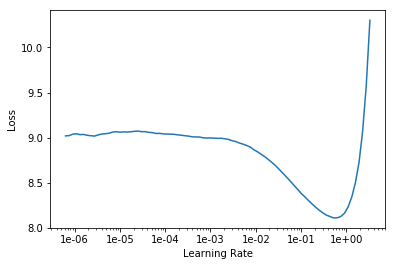

In [166]:
#lowest point is 1, back one magnitude is 0.1 per https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d
learn.recorder.plot()

In [167]:
#adjusting the learning rate based on lr find already improved the results of the first cycle of training
learn.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,6.243509,5.596466,0.193435,36:39
1,6.153902,5.339222,0.210333,37:13
2,5.615686,5.108628,0.226549,36:53


In [168]:
#unfreezing and training the whole model
#implementing new practice of saving my model as I go to load prior states as I experiment

learn.save('lm_initial-fine-tuning')

#when I unfreeze I'm am rerunning the lr_find function to see if I get a different result - 
#authors of the text I read adjusted without explanation

learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


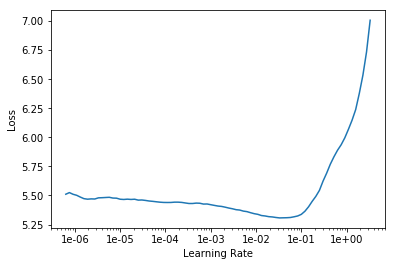

In [169]:
learn.recorder.plot()

In [170]:
#training for one more epoch with the new learning rate after unfreezing the whole model
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.824279,4.565581,0.278814,1:14:31


In [171]:
#seeing a large improvement in training the whole model, running again
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.413591,4.311911,0.307753,55:15


In [172]:
learn.save('lm_307753_acc')

In [40]:
#this is from last time, did not run this time
#learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.260316,4.294232,0.312242,26:13


In [173]:
#trying out the tensorboard writer and intrinsic attention

#learn.save('lm_train_whole_model_3ep')

learn.predict("dow jones industrial average", 10)


'dow jones industrial average as offering deal over 575 m funding round xxbos all'

In [ ]:
#I probably don't need to import all of these...I'll do more research to figure out just what I'm using below

from fastai.torch_core import *
from fastai.callback import *
from fastai.layers import *
from fastai.basic_train import LearnerCallback

#based on fastai's built in fbeta and accuracy metrics - the fbeta that is built in only works on one hot encoded multiclass targets

def fscore(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=1, eps:float=1e-9, sigmoid:bool=True)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
    n = y_true.shape[0]
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = y_pred.argmax(dim=-1).view(n,-1)
    y_true = y_true.view(n,-1)
    TP = (y_pred*y_true).float().sum()
    prec = TP/(y_pred.float().sum()+eps)
    rec = TP/(y_true.float().sum()+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.float().mean()

In [174]:
#not using my fscore, doesn't change model behavior but does prevent the model from being easily transferable

#from fastai import metrics

learn.save_encoder('ft_enc')
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
#learn.load('ulmfit_export')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


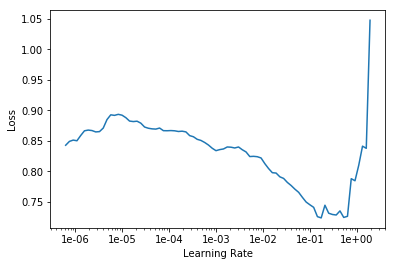

In [175]:
learn.lr_find()
learn.recorder.plot()

In [176]:
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.375256,0.303822,0.878932,13:21


In [177]:
learn.save('tc_1_ep')
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.339907,0.275959,0.895252,29:17


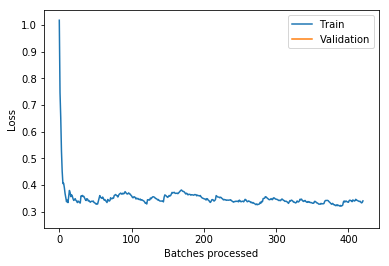

In [178]:
learn.save('tc_2_ep')
learn.recorder.plot_losses()

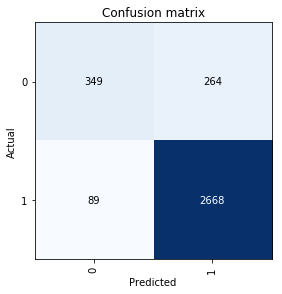

In [179]:
txt_ci = TextClassificationInterpretation.from_learner(learn)
txt_ci.plot_confusion_matrix()

In [180]:
predictions = learn.get_preds()

In [205]:
df = pd.DataFrame([i.tolist() for i in predictions[0]])
df['target'] = [i for i in predictions[1].tolist()]
df.columns = ['0','1','target']
df.head()

,0,1,target
0,0.174542,0.825458,1
1,0.159065,0.840935,0
2,0.301049,0.698951,0
3,0.204852,0.795148,0
4,0.348087,0.651913,1


In [206]:
df['predictions'] = [1 if row[0] < row[1] else 0 for i,row in df[['0','1']].iterrows()]
df.head()

,0,1,target,predictions
0,0.174542,0.825458,1,1
1,0.159065,0.840935,0,1
2,0.301049,0.698951,0,1
3,0.204852,0.795148,0,1
4,0.348087,0.651913,1,1


In [210]:
learn.save('cl_train_2ep')

In [211]:
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.339897,0.268041,0.894362,17:21


In [212]:
learn.load('cl_train_2ep')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (13478 items)
x: TextList
xxbos xxmaj disney aims to xxunk xxmaj star xxmaj wars fans of all kinds at u s parks,xxbos whatsapp new update brings mark as unread google drive backup and more new features,xxbos xxmaj exclusive xxmaj impossible xxmaj foods raises million with investors eager for bite of xxunk burgers,xxbos google docs adds new animal avatars for endangered species day,xxbos google launches privacy tools to limit online tracking in chrome browser
y: CategoryList
1,1,1,1,1
Path: .;

Valid: LabelList (3370 items)
x: TextList
xxbos amazon save up to on select little tikes toys today only,xxbos xxmaj from i xxmaj believe to xxmaj xxunk xxmaj the xxmaj jonas xxmaj brothers xxmaj sweetest xxmaj lyrics xxmaj about xxmaj their xxmaj xxunk on xxmaj happiness xxmaj begins,xxbos google showcases nest hub max smart display at io developer conference,xxbos survey says greensboro workers want good schools green space and google access,

In [216]:
learn.predict("Gambling Stock Roundup: WYNN to Sell Massachusetts Casino, DIS &amp; CZR Ink Deal")

(Category 0, tensor(0), tensor([0.8721, 0.1279]))

In [218]:
from sklearn.metrics import f1_score

f1_score(df['predictions'], df['target'])

0.9379504306556513

In [219]:
txt_ci.show_top_losses(10)

Text,Prediction,Actual,Loss,Probability
xxbos xxmaj stocks to xxmaj build xxmaj your xxmaj portfolio xxmaj around,0,0,4.91,0.99
xxbos google revamps ecommerce ads pitch with new formats and shopping hub,1,1,4.78,0.99
xxbos google assistant is coming to select bose smart speakers,0,1,4.78,0.01
xxbos amazon technologies assigned patent for antenna structures,0,1,4.37,0.01
xxbos shohei ohtani to return to angels hitting order daily life a struggle for most venezuelans can the use of ai weapons be banned where is the uk now on brexit amazon deal highlights ideological fissures within the democratic party newsline in depth newsline in depth newsline in depth newsline in depth newsline in depth newsline in depth,1,1,3.98,0.98
xxbos who was omar khayyam google doodle celebrates pioneering persian astronomer and poet,1,1,3.97,0.98
xxbos amazon web services sydney summit set to unveil the latest global technology trends,1,1,3.92,0.98
xxbos public health facilities with emergency services on google maps,1,1,3.88,0.98
xxbos google cuts off huawei avengers surpasses avatar,1,1,3.81,0.98
xxbos google maps now shows speed limits and speed cameras in countries,0,1,3.72,0.02


In [214]:
import warnings
warnings.filterwarnings('ignore')

error_analysis = pd.DataFrame(pd.read_csv(r'C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\output_data\error_analysis.csv'))
error_analysis.head()

ulmfit_preds = error_analysis['headline'].apply(lambda row: str(learn.predict(row)[0]))

print(ulmfit_preds[:5])
#learn.predict("This was a great movie!")

0    0
1    1
2    1
3    0
4    1
Name: headline, dtype: object


In [220]:
error_analysis['ulmfit_classification'] = ulmfit_preds

error_analysis.head()

,Unnamed: 0,headline,actual_classification,logistic_regression_classification,xgboost_classification,ulmfit_classification
0,9967,what's new on netflix hulu amazon and hbo this...,0,0,1,0
1,16710,"Samsung TVs, HP monitors, Morphy Richards slow...",0,0,1,1
2,14416,amazon 1day shipping lifts startups serving wa...,0,1,1,1
3,15485,Imagine Owning Apple Hospitality REIT (NYSE:AP...,0,0,1,0
4,11812,"Corteva Agriscience Set to Incorporate DuPont,...",0,1,1,1


In [223]:
error_analysis[['headline','actual_classification','ulmfit_classification']][error_analysis.actual_classification != error_analysis.ulmfit_classification].to_csv(r"C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\output_data\error_analysis.csv")